In [78]:
import joblib
from xgboost import XGBRegressor
from rdkit import Chem
from rdkit.Chem import Crippen
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from tqdm.auto import tqdm
from plot_regression import plot_regression

I had to do a bit of manipulation to get the CSD melting point model to load with newer versions of XGBoost.  The version of the model in the OpenSOL GitHub repo was created with XGBoost 1.5 (or earlier) and saved using joblib.  I ended up installing XGBoost 1.5 and saving the model as json.  The json version is compatible with more recent versions of XGBoost. 
<pre>
import joblib
model = joblib.load("xgboost_rdkit_2d_clustering_model.job")
model.save_model("xgboost_rdkit_2d_clustering_model.json")
</pre>

In [57]:
xgb = XGBRegressor()
xgb.load_model("xgboost_rdkit_2d_clustering_model.json")

This is descriptor calculation code that I borrowed from the OpenSOL github repo. 

In [68]:
def rdkit_2d_calc(mols, names=False, Autocorr2D=True):

    DescList = Descriptors.descList
    DscrNames = {}

    if Autocorr2D == True:
        DscrNames['Types'] = ['2D', 'Autocorr2D']
    else:
        DscrNames['Types'] = ['2D']

    DscrNames['Functions'] = {}

    for Type in DscrNames["Types"]:
        DscrNames[Type] = {}
        DscrNames[Type]["Names"] = []
        DscrNames["Functions"][Type] = []

    for Type in DscrNames['Types']:
        if Type == '2D':
            for dscr in DescList:
                DscrNames[Type]["Names"].append(dscr[0])
                DscrNames["Functions"][Type].append(dscr[1])
        elif Type == 'Autocorr2D':
            # The current rdkit has 192 Autocorr2D descriptors as of 04_14_2022
            COUNT = 192
            DscrNames[Type]["Names"] = ['Autocorr2D_{}'.format(i) for i in range(COUNT)]
            DscrNames["Functions"][Type] = rdMolDescriptors.CalcAUTOCORR2D

    dscr_names = Names_generator(DscrNames)

    if names:
        assert len(mols) == len(names)
        idx = names
    else:
        idx = list(range(len(mols)))

    df_dscr = pd.DataFrame(np.nan, index=idx, columns=dscr_names)

    for mol, name in tqdm(zip(mols, idx),total=len(df_dscr)):
        if mol:
            df_dscr.loc[name] = Values_generator(mol, DscrNames)

    return(df_dscr)

def Names_generator(DscrNames):
    dscr_names = []
    for Type in DscrNames['Types']:
        for Name in DscrNames[Type]['Names']:
            dscr_names.append(Name)
    return dscr_names

def Values_generator(mol, DscrNames):
    dscr_values = []
    for Type in DscrNames['Types']:
        if Type in ['2D', '3D']:
            for Function in DscrNames['Functions'][Type]:
                dscr_values.append(Function(mol))
        else:
            dscr_values.extend(DscrNames['Functions'][Type](mol))
    return dscr_values

def clogP_calc(mols):
    clogp = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        clogp.append(Crippen.MolLogP(mol))
    return clogp

Read the Biogen solubility dataset

In [69]:
df = pd.read_csv("biogen_solubility.csv")

Add a molecule column to the dataframe

In [70]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Calcluate the molecular descriptors

In [71]:
desc_df = rdkit_2d_calc(df.mol.values,Autocorr2D=False)

  0%|          | 0/2173 [00:00<?, ?it/s]

Predict the melting point and add the predicted melting point to the dataframe

In [75]:
df['mp'] = xgb.predict(np.stack(desc_df.to_numpy()))

Calculate CLogP for the molecules in the dataframe

In [76]:
df['clogp'] = clogP_calc(df.mol.values)

Calculate solubility using the GSE

In [77]:
df['pred_sol'] = 0.5 - 0.01 * (df.mp - 25 - 273.15) - df.clogp

Plot the model performance

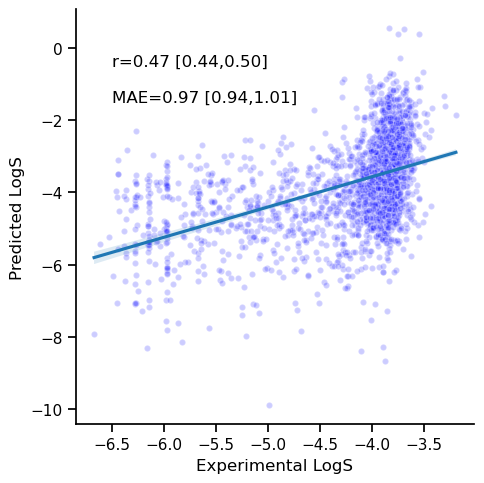

In [80]:
plot_regression(df.logS,df.pred_sol)